# Popularity of Baby Names
Analysis of the popularity of baby names using data from the SSA.gov dataset.

In [1]:
import io, os, requests, zipfile

url="https://www.ssa.gov/oact/babynames/names.zip"
directory="./data/"
namesDirectory=os.path.join(directory, "names")

if not os.path.exists(namesDirectory):
    r = requests.get(url)
    assert r.ok
    with zipfile.ZipFile(io.BytesIO(r.content)) as zip:
        zip.extractall(namesDirectory)

Combine the yearly data into a single CSV. Filter to a single gender while we're at it, mostly because it simplifies the name key in the dictionary I'm using to combine data.


In [24]:
startYear=1921
endYear=2021

combined_filename=os.path.join(directory, f"combined-{startYear}-{endYear}.csv")
if not os.path.exists(combined_filename):

    # Read all the names from each year between start..end
    #    1. Merge into a single CSV keyed by Name + Sex
    #    2. Write to a new csv file with a column per year
    all_the_names={}
    for year in range(startYear, endYear + 1):
        filename=os.path.join(namesDirectory, f"yob{year}.txt")
        with open(filename, "r") as names:
            for line in names:
                name, sex, count = line.split(",")
                key = (str.strip(name), str.strip(sex))
                count = int(count)

                if key not in all_the_names.keys():
                    all_the_names[key] = {}

                all_the_names[key][year] = count
    
    with open(combined_filename, "w") as combined:
        combined.write("Name,Sex")
        for year in range(startYear, endYear + 1):
            combined.write(f",{year}")
        combined.write("\n")

        for key, counts in all_the_names.items():
            name, sex = key
            combined.write(f"{name},{sex}")
            for year in range(startYear, endYear + 1):
                combined.write(f",{0 if year not in counts.keys() else counts[year]}")
            combined.write("\n")

Load the combined file into a Pandas Dataframe. Split the dataframe by gender and normalize to *approximately* the count per million. Disclaimer: I don't know how normalized this data is.

In [42]:
import numpy as np
import pandas as pd

names = pd.read_csv(combined_filename).set_index(['Sex', 'Name'])

names_female = names[names.index.get_level_values('Sex') == "F"]
names_female = pd.concat([(1_000_000 * series / series.sum()).round().astype(int) for header, series in names_female.items()], axis=1)

names_male = names[names.index.get_level_values('Sex') == "M"]
names_male = pd.concat([(1_000_000 * series / series.sum()).round().astype(int) for header, series in names_male.items()], axis=1)

names = pd.concat([names_female, names_male])

# for year in range(startYear, endYear + 1):
#     df = df.sort_values(by=f"{year}", ascending=False)
#     df[f"{year}_rank"] = df.reset_index(drop=True).index + 1    

## Top Name Trends
Plot the popularity of the top 10 names from certain years.

In [46]:
topTenFemaleNames = names_female.nlargest(10, "1991")
topTenMaleNames = names_male.nlargest(10, "1991")
pd.concat([topTenFemaleNames,topTenMaleNames]).transpose()

Sex       F                                                            \
Name Ashley Jessica Brittany Amanda Samantha Sarah Stephanie Jennifer   
1921      0      39        0    318       24  4074       247        4   
1922      0      33        0    284       23  4148       186        6   
1923      0      43        0    300       18  4114       201        7   
1924      0      33        0    273       12  4040       180        9   
1925      0      28        0    255       16  3849       136        7   
...     ...     ...      ...    ...      ...   ...       ...      ...   
2017   1467     746      233    558     2510  2339       658      609   
2018   1342     628      181    503     2307  2220       605      542   
2019   1209     577      190    459     2012  1979       534      469   
2020   1116     483      164    429     1830  1898       434      440   
2021   1039     398      173    401     1588  1736       420      389   

Sex                        M                                                  \
Name Elizabeth Emily Michael Christopher Matthew Joshua Andrew Daniel  James   
1921     12814  1771    3811         264     830    113   3645   3711  45167   
1922     12692  1787    3667         282     903    114   3493   3938  45768   
1923     12815  1705    3572         268     853    118   3420   3890  46039   
1924     11971  1637    3420         262     751    101   3306   3887  46737   
1925     11447  1451    3370         256     753     98   3241   4077  47208   
...        ...   ...     ...         ...     ...    ...    ...    ...    ...   
2017      5214  5689    6864        4494    6339   4505   4477   6346   7762   
2018      5054  5127    6463        4036    5514   4096   4025   6218   7514   
2019      4722  4923    5913        3906    5167   3692   3794   5901   7357   
2020      4516  4287    5694        3593    4717   3478   3513   5516   7183   
2021      4419  4020    5213        3350    4278   3152   3212   5228   7131   

Sex                       
Name David Joseph   John  
1921  7051  23770  52852  
1922  7228  23617  52640  
1923  7508  23320  52429  
1924  7732  22441  52132  
1925  7991  22057  51257  
...    ...    ...    ...  
2017  5531   5663   5148  
2018  5401   5326   5066  
2019  5004   5102   4938  
2020  4788   4906   4793  
2021  4522   4652   4688  

[101 rows x 20 columns]

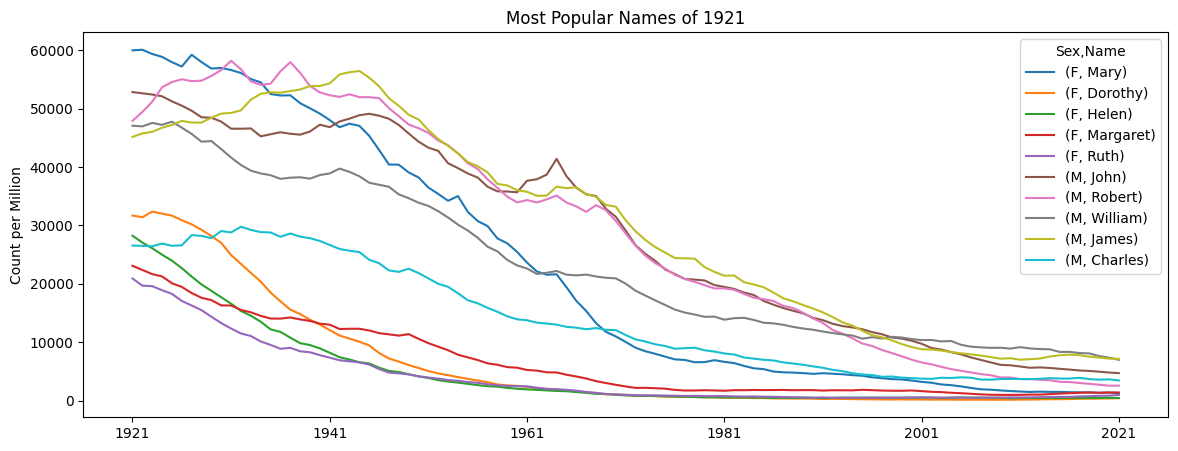

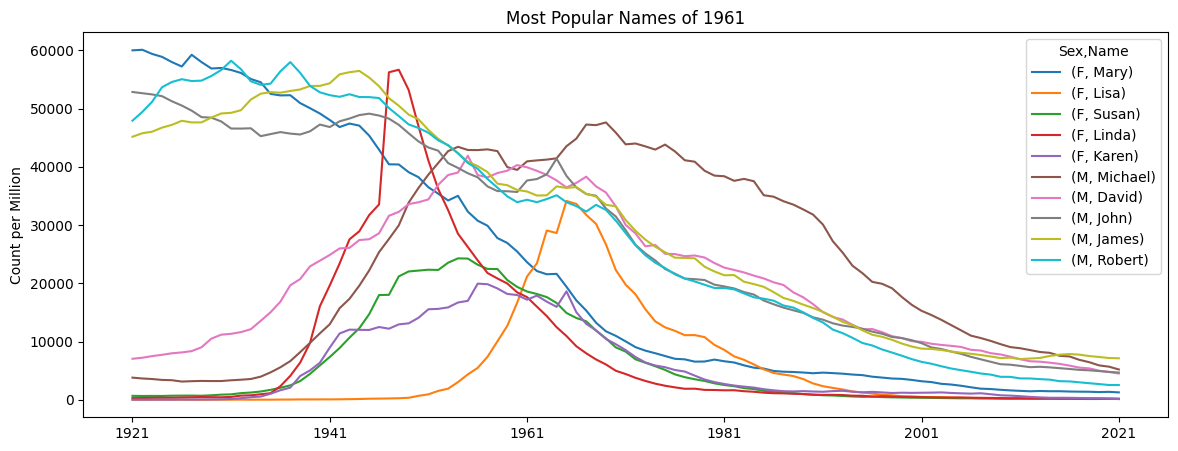

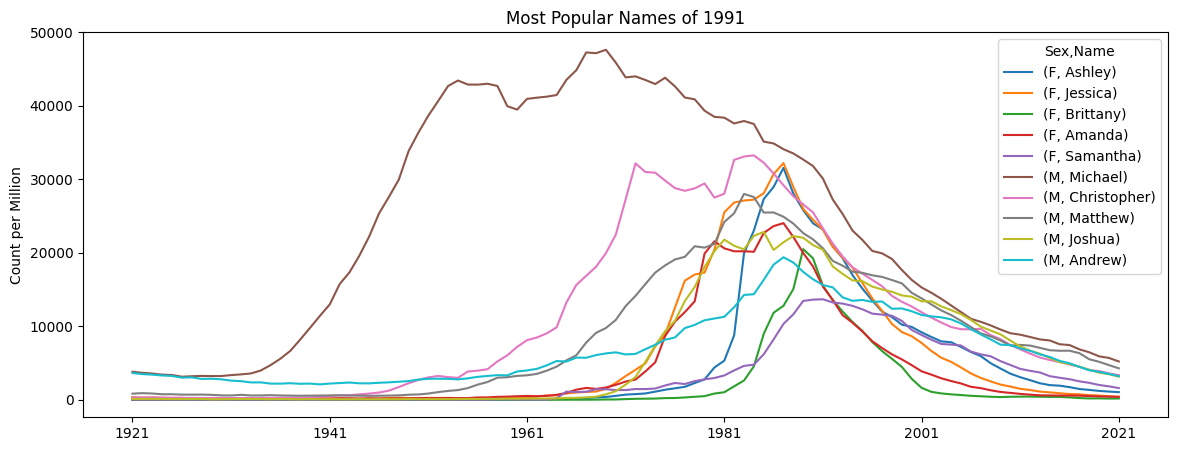

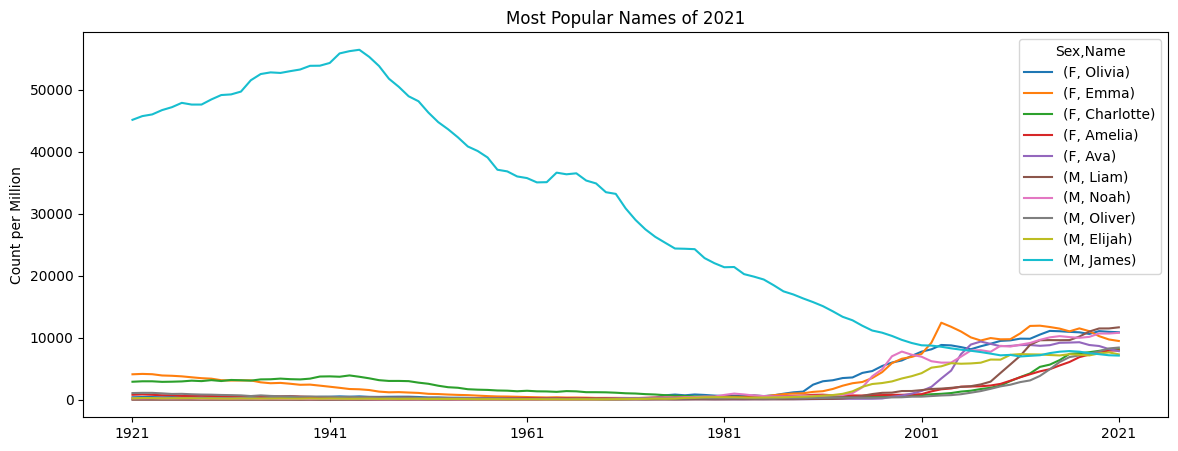

In [48]:
yearsToPlot = [ 1921, 1961, 1991, 2021 ]

for year in yearsToPlot:
    topFemaleNames = names_female.nlargest(5, f"{year}")
    topMaleNames = names_male.nlargest(5, f"{year}")
    pd.concat([topFemaleNames,topMaleNames]) \
        .transpose() \
        .plot(title=f"Most Popular Names of {year}", ylabel="Count per Million", figsize=(14,5))


<AxesSubplot: title={'center': 'Name Popularity from 1921 to 2021'}, ylabel='Count per Million'>

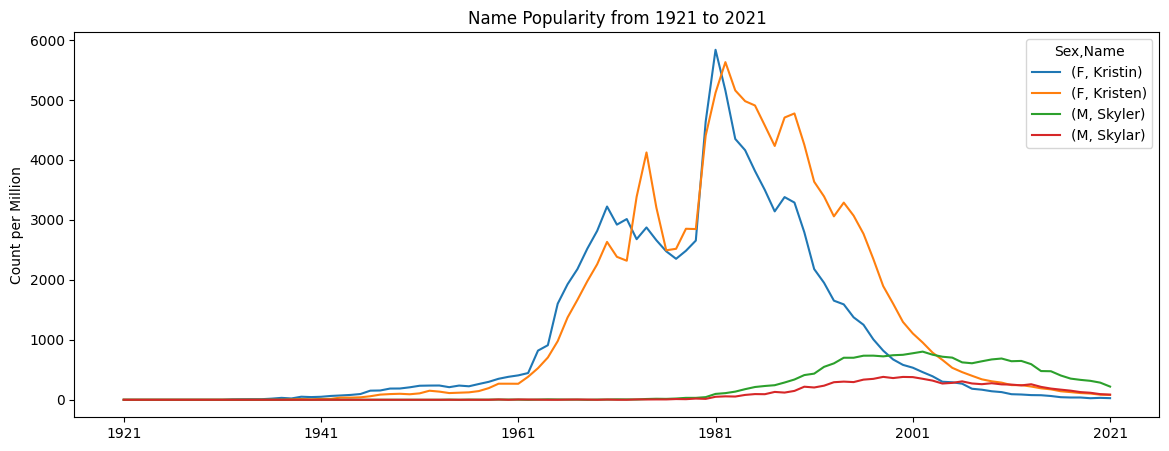

In [49]:
names_to_plot = [ ('F', 'Kristin'), ('F', 'Kristen'), ('M', 'Skyler'), ('M', 'Skylar') ] 
names.loc[names_to_plot] \
    .transpose() \
    .plot(title=f"Name Popularity from {startYear} to {endYear}", ylabel="Count per Million", figsize=(14,5))